In [67]:
import numpy as np
import pandas as pd
import matplotlib
from chart_studio.plotly import plotly
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
import lightgbm as lgb
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics
# import plotly.plotly as py # visualization library
from plotly.offline import init_notebook_mode, iplot # plotly offline mode
init_notebook_mode(connected=True) 
import plotly.graph_objs as go # plotly graphical object
# import warnings library
import warnings        
# ignore filters
warnings.filterwarnings("ignore") # if there is a warning after some codes, this will avoid us to see them.
plt.style.use('ggplot') # style of plots. ggplot is one of the most used style, I also like it.
# Any results you write to the current directory are saved as output.
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [68]:
df = pd.read_csv("./Gia SMP va SMPcap 2021(Giá thị trường SMP).csv", encoding="latin-1", sep =';')
df.head(5)

,Ngày,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,01/01/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
1,01/02/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
2,01/03/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
3,01/04/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
4,01/05/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5


In [69]:
feats = ['4', '5']
df[feats].head()

,4,5
0,964.4,964.4
1,1019.7,1019.7
2,988.4,988.4
3,1002.0,1002.0
4,1061.5,1061.5


## EDA Data


In [70]:
df[feats].isna().sum()

4    0
5    0
dtype: int64

In [71]:
import plotly.express as px
fig = px.line(y=df['4'], x=df['Ngày'])
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Ngày", 
                  yaxis_title="Cột 4",
                  title={'text': "Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(53,223,0,0.8)')

In [72]:
fig = px.line(y=df['5'], x=df['Ngày'])
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Ngày", 
                  yaxis_title="Cột 5",
                  title={'text': "Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(53,223,0,0.8)')

In [73]:
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler()
X = transformer.fit_transform(np.array(df[feats]))

In [74]:
X[:5]

array([[-0.72215304, -0.72216096],
       [-0.19550131, -0.19550725],
       [-0.49358809, -0.49359515],
       [-0.36406796, -0.36407453],
       [ 0.20258265,  0.20257818]])

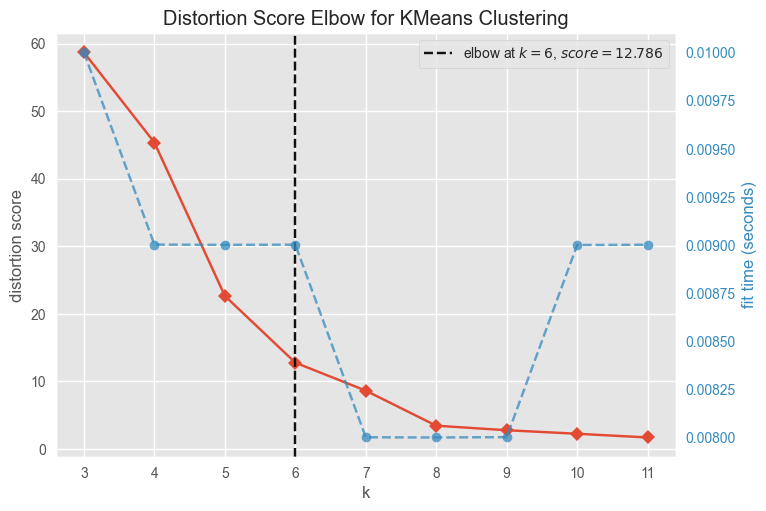

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [75]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

Elbow_M = KElbowVisualizer(KMeans(random_state=23), k=(3,12))
Elbow_M.fit(X)
Elbow_M.show()

## Gaussian

In [76]:
BGM = BayesianGaussianMixture(n_components=6,covariance_type='full',random_state=1,n_init=12)
preds = BGM.fit_predict(X)
df["Clusters"]= preds

In [77]:
pp=BGM.predict_proba(X)
df_new=pd.DataFrame(X,columns=feats) 
df_new[[f'predict_proba_{i}' for i in range(6)]]=pp 
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(6):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))


In [78]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
X_new=df_new.loc[train_index][feats]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7} 

model_list=[]

gkf = StratifiedKFold(5)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = feats)
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = feats)
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 

[200]	valid_0's multi_logloss: 0.000176965
[400]	valid_0's multi_logloss: 0.000176965
[200]	valid_0's multi_logloss: 0.000221568
[400]	valid_0's multi_logloss: 0.000221568
[200]	valid_0's multi_logloss: 0.000220866
[400]	valid_0's multi_logloss: 0.000220866
[200]	valid_0's multi_logloss: 1.15973e-05
[400]	valid_0's multi_logloss: 1.15455e-05
[600]	valid_0's multi_logloss: 1.15116e-05
[800]	valid_0's multi_logloss: 1.14878e-05
[1000]	valid_0's multi_logloss: 1.14701e-05
[1200]	valid_0's multi_logloss: 1.14565e-05
[1400]	valid_0's multi_logloss: 1.14457e-05
[1600]	valid_0's multi_logloss: 1.1437e-05
[1800]	valid_0's multi_logloss: 1.14297e-05
[2000]	valid_0's multi_logloss: 1.14236e-05
[2200]	valid_0's multi_logloss: 1.14184e-05
[2400]	valid_0's multi_logloss: 1.14139e-05
[2600]	valid_0's multi_logloss: 1.141e-05
[2800]	valid_0's multi_logloss: 1.14066e-05
[3000]	valid_0's multi_logloss: 1.14035e-05
[3200]	valid_0's multi_logloss: 1.14008e-05
[3400]	valid_0's multi_logloss: 1.13984e-05
[

In [79]:
lgb_preds=0
for model in model_list:
    lgb_preds += model.predict(df_new[feats])

In [80]:
labels = np.argmax(lgb_preds,axis=1)

In [81]:
u = np.unique(labels)
u

array([0, 1, 2], dtype=int64)

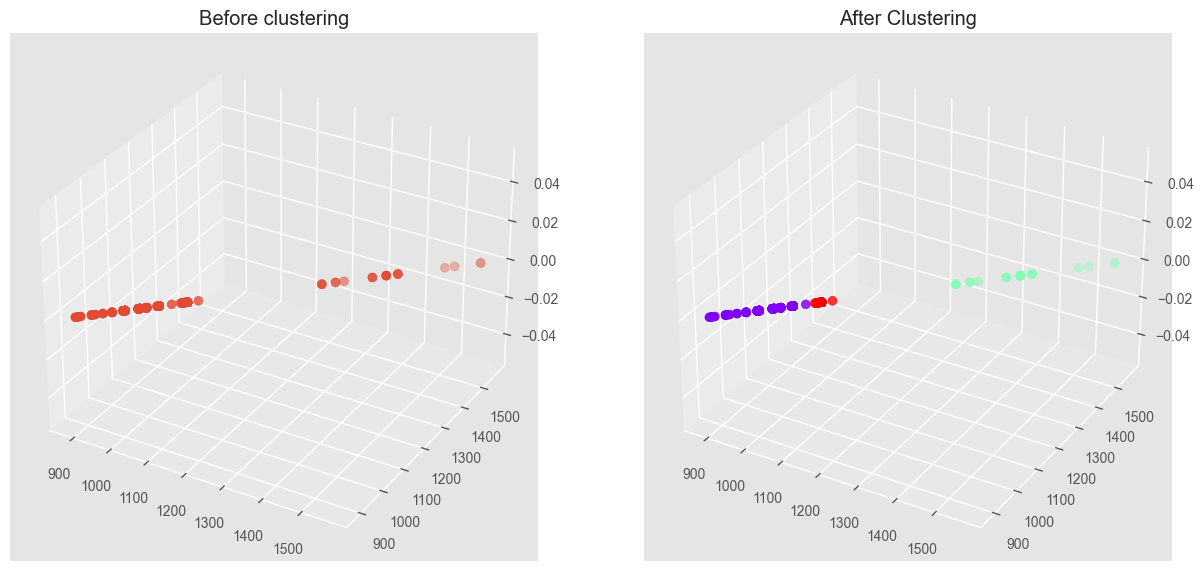

In [82]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(1,2,1, projection='3d', label="bla")
ax.scatter(df['4'], df['5'], s=40, marker='o', cmap = 'rainbow' )
ax.set_title("Before clustering")
ax = plt.subplot(1,2,2, projection='3d', label="bla")
ax.scatter(df['4'], df['5'], s=40, c=df["Clusters"], marker='o',cmap="rainbow")
ax.set_title("After Clustering")
plt.show()

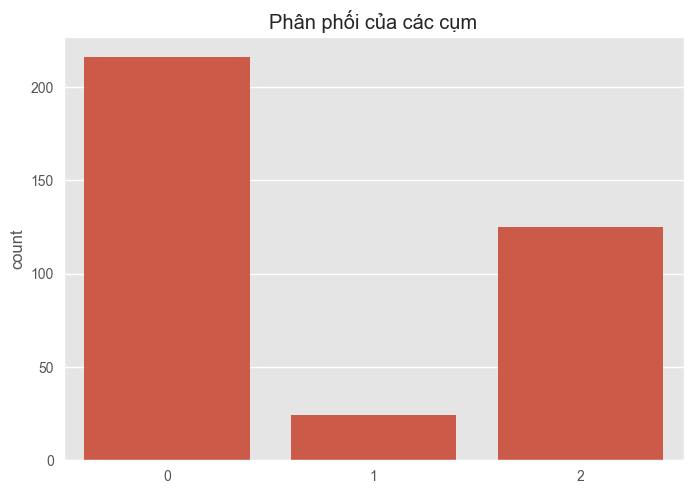

In [83]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Phân phối của các cụm")
plt.show()

In [84]:
BGM = BayesianGaussianMixture(n_components=4,covariance_type='full',random_state=1,n_init=12)
preds = BGM.fit_predict(X)
df["Clusters"]= preds

In [85]:
pp=BGM.predict_proba(X)
df_new=pd.DataFrame(X,columns=feats) 
df_new[[f'predict_proba_{i}' for i in range(4)]]=pp 
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(4):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [86]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
X_new=df_new.loc[train_index][feats]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7} 

model_list=[]

gkf = StratifiedKFold(5)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = feats)
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = feats)
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 

[200]	valid_0's multi_logloss: 0.000213082
[400]	valid_0's multi_logloss: 0.000213082
[200]	valid_0's multi_logloss: 0.000220447
[400]	valid_0's multi_logloss: 0.000220447
[200]	valid_0's multi_logloss: 0.000220866
[400]	valid_0's multi_logloss: 0.000220866
[200]	valid_0's multi_logloss: 1.04712e-05
[400]	valid_0's multi_logloss: 1.04236e-05
[600]	valid_0's multi_logloss: 1.03923e-05
[800]	valid_0's multi_logloss: 1.03703e-05
[1000]	valid_0's multi_logloss: 1.0354e-05
[1200]	valid_0's multi_logloss: 1.03415e-05
[1400]	valid_0's multi_logloss: 1.03316e-05
[1600]	valid_0's multi_logloss: 1.03235e-05
[1800]	valid_0's multi_logloss: 1.03168e-05
[2000]	valid_0's multi_logloss: 1.03112e-05
[2200]	valid_0's multi_logloss: 1.03064e-05
[2400]	valid_0's multi_logloss: 1.03023e-05
[2600]	valid_0's multi_logloss: 1.02987e-05
[2800]	valid_0's multi_logloss: 1.02956e-05
[3000]	valid_0's multi_logloss: 1.02928e-05
[3200]	valid_0's multi_logloss: 1.02903e-05
[3400]	valid_0's multi_logloss: 1.0288e-05


In [87]:
lgb_preds = 0
for model in model_list:
    lgb_preds += model.predict(df_new[feats])
labels=np.argmax(lgb_preds,axis=1)

In [88]:
u = np.unique(labels)
u

array([0, 1, 2], dtype=int64)

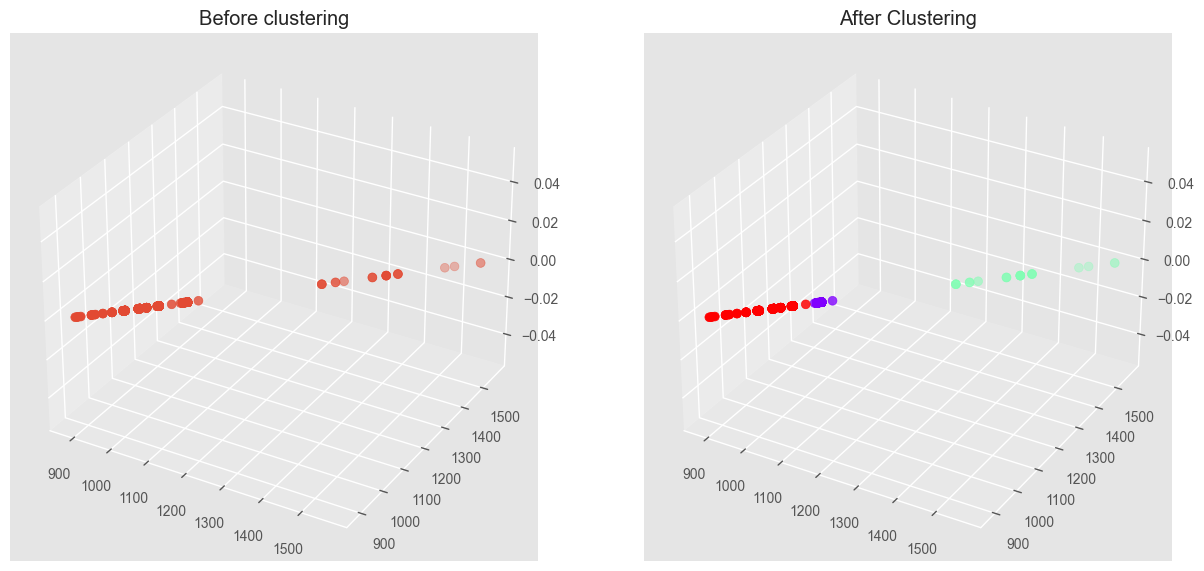

In [89]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(1,2,1, projection='3d', label="bla")
ax.scatter(df['4'], df['5'], s=40, marker='o', cmap = 'rainbow' )
ax.set_title("Before clustering")
ax = plt.subplot(1,2,2, projection='3d', label="bla")
ax.scatter(df['4'], df['5'], s=40, c=df["Clusters"], marker='o',cmap="rainbow")
ax.set_title("After Clustering")
plt.show()

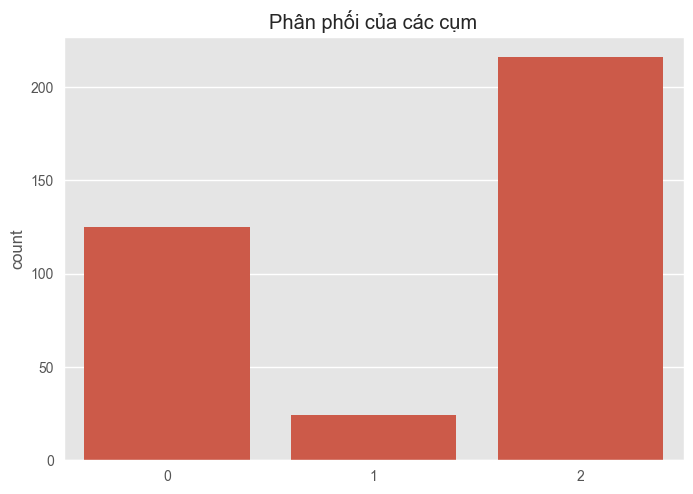

In [90]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Phân phối của các cụm")
plt.show()

In [91]:
BGM = BayesianGaussianMixture(n_components=3,covariance_type='full',random_state=1,n_init=12)
preds = BGM.fit_predict(X)
df["Clusters"]= preds

In [92]:
pp=BGM.predict_proba(X)
df_new=pd.DataFrame(X,columns=feats) 
df_new[[f'predict_proba_{i}' for i in range(3)]]=pp 
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(3):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [93]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
X_new=df_new.loc[train_index][feats]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7} 

model_list=[]

gkf = StratifiedKFold(5)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = feats)
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = feats)
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model)

[200]	valid_0's multi_logloss: 0.000176965
[400]	valid_0's multi_logloss: 0.000176965
[200]	valid_0's multi_logloss: 0.000221568
[400]	valid_0's multi_logloss: 0.000221568
[200]	valid_0's multi_logloss: 0.000220866
[400]	valid_0's multi_logloss: 0.000220866
[200]	valid_0's multi_logloss: 1.15973e-05
[400]	valid_0's multi_logloss: 1.15455e-05
[600]	valid_0's multi_logloss: 1.15116e-05
[800]	valid_0's multi_logloss: 1.14878e-05
[1000]	valid_0's multi_logloss: 1.14701e-05
[1200]	valid_0's multi_logloss: 1.14565e-05
[1400]	valid_0's multi_logloss: 1.14457e-05
[1600]	valid_0's multi_logloss: 1.1437e-05
[1800]	valid_0's multi_logloss: 1.14297e-05
[2000]	valid_0's multi_logloss: 1.14236e-05
[2200]	valid_0's multi_logloss: 1.14184e-05
[2400]	valid_0's multi_logloss: 1.14139e-05
[2600]	valid_0's multi_logloss: 1.141e-05
[2800]	valid_0's multi_logloss: 1.14066e-05
[3000]	valid_0's multi_logloss: 1.14035e-05
[3200]	valid_0's multi_logloss: 1.14008e-05
[3400]	valid_0's multi_logloss: 1.13984e-05
[

In [94]:
lgb_preds=0
for model in model_list:
    lgb_preds += model.predict(df_new[feats])
labels=np.argmax(lgb_preds,axis=1)

In [95]:
u = np.unique(labels)
u

array([0, 1, 2], dtype=int64)

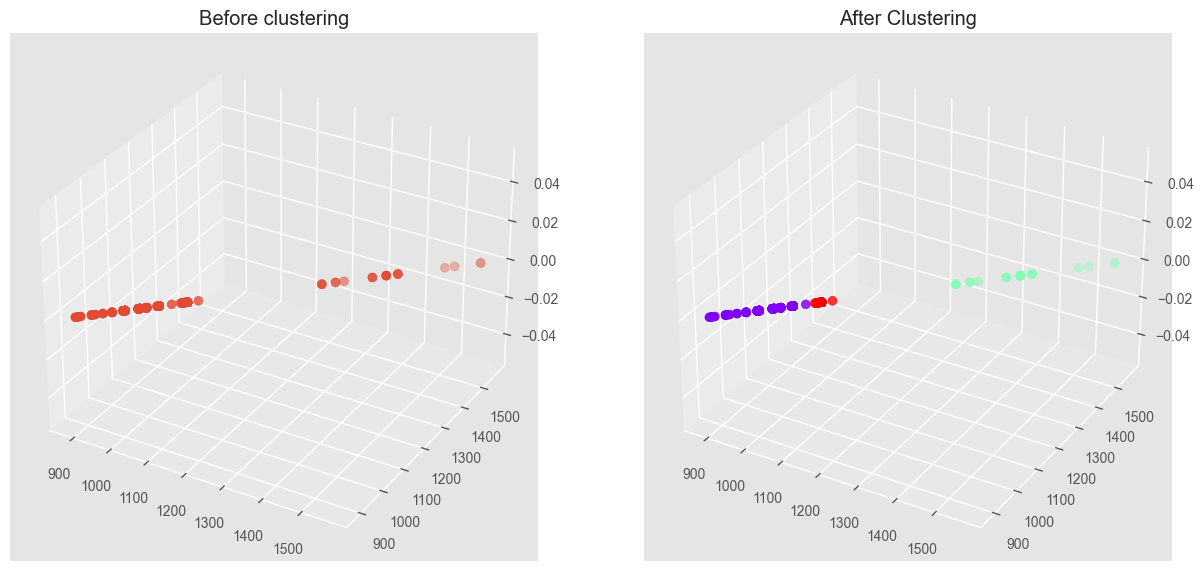

In [96]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(1,2,1, projection='3d', label="bla")
ax.scatter(df['4'], df['5'], s=40, marker='o', cmap = 'rainbow' )
ax.set_title("Before clustering")
ax = plt.subplot(1,2,2, projection='3d', label="bla")
ax.scatter(df['4'], df['5'], s=40, c=df["Clusters"], marker='o',cmap="rainbow")
ax.set_title("After Clustering")
plt.show()

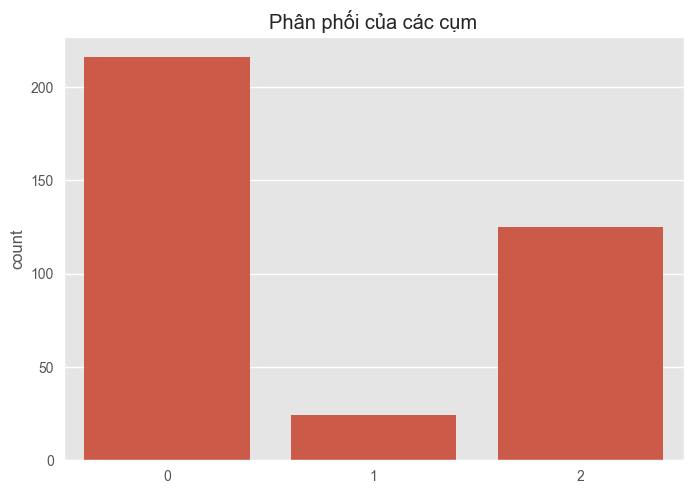

In [97]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Phân phối của các cụm")
plt.show()

In [98]:
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

In [99]:
feats = ['Ngày', '4', '5']

In [100]:
df = df[feats]
df

,Ngày,4,5
0,01/01/2021,964.4,964.4
1,01/02/2021,1019.7,1019.7
2,01/03/2021,988.4,988.4
3,01/04/2021,1002.0,1002.0
4,01/05/2021,1061.5,1061.5
...,...,...,...
360,27/12/2021,1002.0,1002.0
361,28/12/2021,1002.0,1002.0
362,29/12/2021,1061.5,1061.5
363,30/12/2021,1022.6,1022.6


In [101]:
df['Ngày'] = pd.to_datetime(df['Ngày'], format='%d/%m/%Y')
df.sort_values(by='Ngày', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [102]:
test_size = df[df['Ngày'].dt.month==12].shape[0]
test_size

31

In [103]:
import plotly.express as px
fig = px.line(y=df['5'], x=df['Ngày'])
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Ngày", 
                  yaxis_title="1",
                  title={'text': "Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(53,223,0,0.8)')


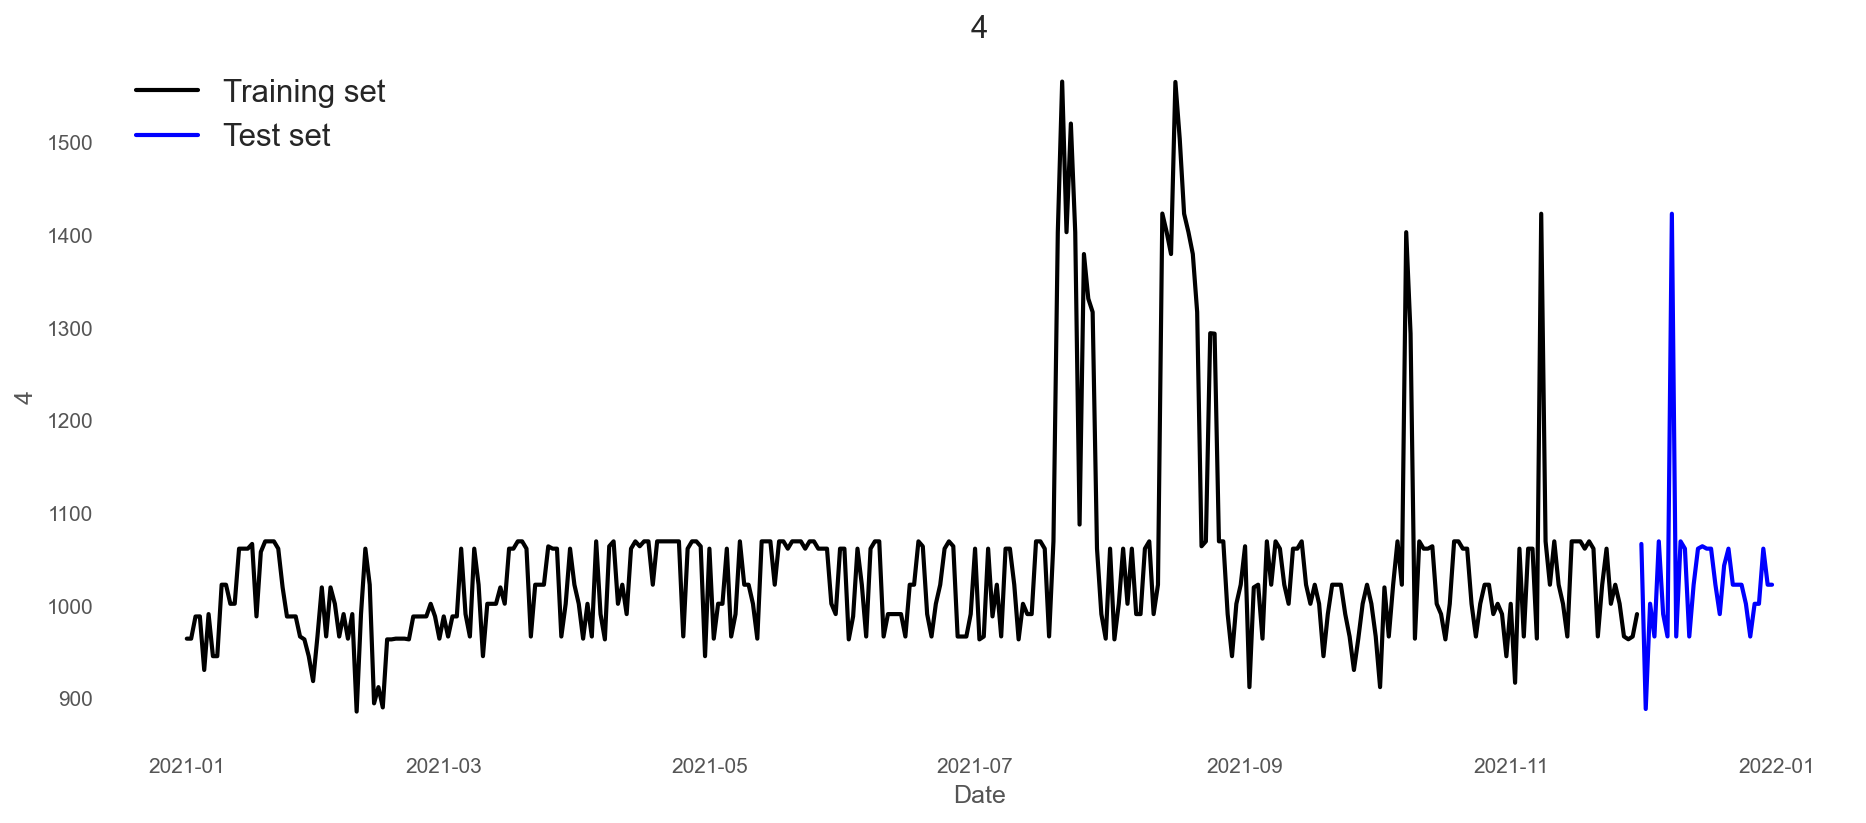

In [104]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Ngày'][:-test_size], df['5'][:-test_size], color='black', lw=2)
plt.plot(df['Ngày'][-test_size:], df['5'][-test_size:], color='blue', lw=2)
plt.title('4', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('4', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [105]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df[['5']])

MinMaxScaler()

In [106]:
window_size = 15

In [107]:
train_data = df[['5']][:-test_size]
train_data = scaler.transform(train_data)

In [108]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

In [120]:
test_data = df[['5']][-test_size-window_size:]
test_data = scaler.transform(test_data)

In [110]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])
    y_test.append(test_data[i, 0])

In [111]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [112]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [113]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64)(input1)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()

    return model

In [114]:
model = define_model()
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 15, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0969 - val_loss: 0.0291
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0331 - val_loss: 0.0168
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0264 - val_loss: 0.0154
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0264 - val_loss: 0.0161
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0365 - val_loss: 0.0156
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0252 - val_loss: 0.0158
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0300 - val_loss: 0.0155
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0286 - val_loss: 0.0155
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0307 - val_loss: 0.0154
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0176 - val_loss: 0.0182
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0231 - val_loss: 0.0165
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0234 - val_l

In [115]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0181
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


In [116]:
from sklearn.metrics import mean_absolute_percentage_error,accuracy_score,r2_score
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1-MAPE

In [117]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.01810230128467083
Test MAPE: 1.802351911950514
Test Accuracy: -0.802351911950514


In [118]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

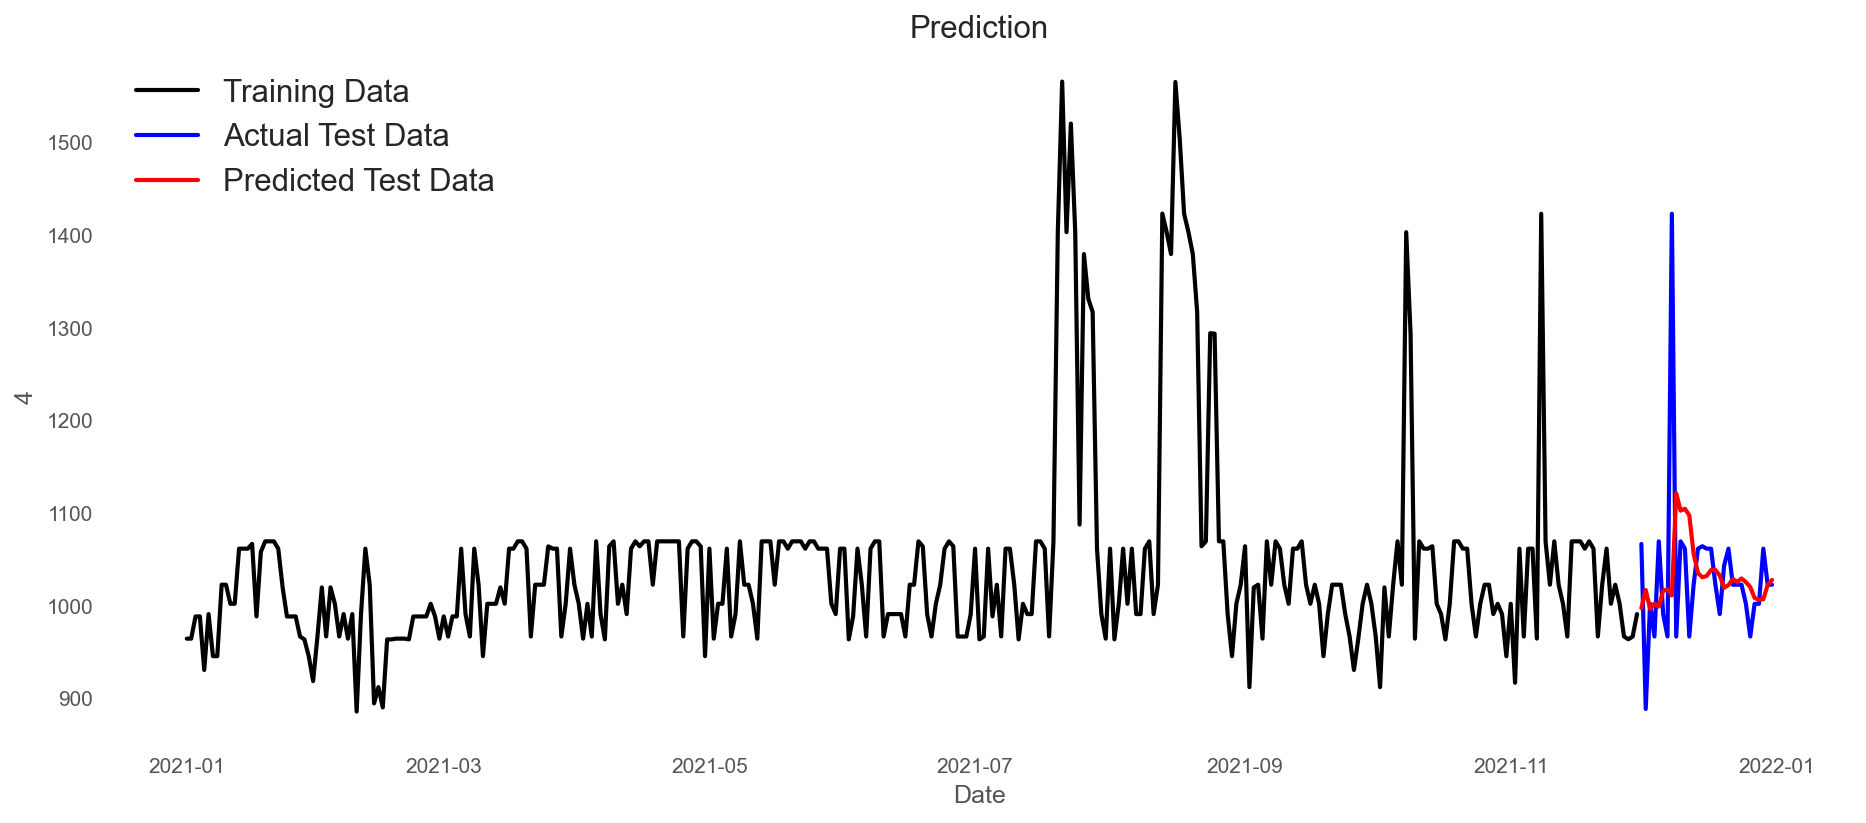

In [119]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Ngày'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Ngày'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Ngày'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('4', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()